# Semantic Similarity Project
Author: Kesi
<br> Date: June 2025
<br> Kernel: workshop_311
<br> Goals: Comp

In [2]:
subj = 'M1008'
print('Subject: ' + subj)

#Import the modules you will need for general analysis
import pprint
import numpy as np
import pandas as pd
import os
import pprint

#Import the modules you need for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Load the necessary tools for word2vec
from gensim.models import KeyedVectors
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors.bin', binary=True)

Subject: M1008


#### Finding the number of sessions & general experoiments' data

In [3]:
# Determine current working dierectory then define path where the patient data is located
# Use the print function to make sure it worked
!pwd
directory_path = '/home1/kesi/semanticSimilarity/Patient_Data' + '/' + str(subj) + '/'
print(directory_path)

/home1/kesi/semanticSimilarity
/home1/kesi/semanticSimilarity/Patient_Data/M1008/


In [4]:
# Get all folder names in the specified directory
folder_names = os.listdir(directory_path)

# Filter the folder names to match the pattern 'Session_X'
sessions = [int(folder.split('_')[1]) for folder in folder_names if folder.startswith('session_')]

# Sort the sessions in case they are not in order
sessions.sort()

# Print the result
print(sessions)

[0, 1]


In [5]:
# First we nned to install cherrypicker
# !pip install cherrypicker

#Then we can import CherryPicker from cherrypicker
#from cherrypicker import CherryPicker

# import json
# from IPython.display import display

# Loop through the list of session numbers
# for session in sessions: 
    # log_file = directory_path + 'session_' + str(session) + '/elemem/event.log'
    
    # with open(log_file) as file:
        # data = [json.loads(line) for line in file] # this makes it read line by line bc its a JSONL file
    
    # picker = CherryPicker(data)
    # flat = picker.flatten().get()
    # df = pd.DataFrame(flat)
    # print(f"Data for session {session}:")
    # print(df)
    # print("\n")
    
    # print(f"\n=== Session {session} ===")
    # display(df.head(5))

In [5]:
import json
import re

stimSitesBySession = []

for session in sessions:
    log_file = directory_path + 'session_' + str(session) + '/elemem/event.log'  # Replace with the actual file path

    # Read the log file
    with open(log_file, "r") as file:
        for line in file:
            # Search for the CONFIGURE type in JSON entries
            if '"type": "CONFIGURE"' in line:
                try:
                    log_entry = json.loads(line.strip())  # Parse JSON
                    if "data" in log_entry and log_entry["data"]:
                        experiment = log_entry["data"].get("experiment", "N/A")
                        session = log_entry["data"].get("session", "N/A")
                        stim_mode = log_entry["data"].get("stim_mode", "N/A")
                        subject = log_entry["data"].get("subject", "N/A")

                        # Print extracted values
                        print(f'Experiment: {experiment}, Session: {session}, Stim Mode: {stim_mode}, Subject: {subject}')
                except json.JSONDecodeError:
                    print("Error parsing JSON")
    

    # Path to the experiment.json file
    json_file = directory_path + 'session_' + str(session) + '/elemem/experiment_config.json'  # Replace with the actual file path

    # Read and parse the JSON file
    with open(json_file, "r") as file:
        data = json.load(file)

    # Extract the electrodes value from stim_channels
    electrodes = data.get("experiment", {}).get("stim_channels", [{}])[0].get("electrodes", "N/A")
    
    stimSitesBySession.append(electrodes)

    # Print the extracted value
    print(f'Electrodes: {electrodes}')

Experiment: MemMapOpenLoop, Session: 0, Stim Mode: open, Subject: M1008
Electrodes: LA4_LA5
Experiment: MemMapOpenLoop, Session: 1, Stim Mode: open, Subject: M1008
Electrodes: LA4_LA5


#### Setting Up Dataframe Structure by Session

In [6]:
dataframes = [[] for _ in range(len(sessions))]
print('number of sessions: ' + str(len(dataframes)))

number of sessions: 2


#### Split up event.log into 4 phases (Encoding, Math Distractor, Cued Recall, Recognition)

In [7]:
def get_rows_between_trials(df):
    # Remove rows where 'type' is 'HEARTBEAT', 'HEARTBEAT_OK', or 'ISI'
    filtered_df = df[~df['type'].isin(['HEARTBEAT', 'HEARTBEAT_OK', 'ISI', 'word stimulus info', 'start trial'])]

    # Initialize variables
    trial_start = None
    all_trial_data = []  # Initialize to an empty list
    all_dataframes = []  # List to hold DataFrames for each trial

    # Check if there's a practice list by inspecting the rows of experimentConfig type
    practice_trial_found = False

    for index, row in filtered_df.iterrows():
        # Check for 'experimentConfig' type and inspect 'data' for 'numPracticeLists'
        # numPracticeList = df.query("type == 'experimentConfig'")['data'].iloc[0]['numPracticeLists']
        practice_trial = df.query("type == 'TRIAL'")['data'].apply(lambda x: x.get('practice', False)).any()

        # Check for the start of a new trial
        if row['type'] == 'TRIAL':
            # Process the previous trial if it exists
            if trial_start is not None and all_trial_data:
                trial_data_df = pd.DataFrame(all_trial_data)

                # Subdivide the trial DataFrame into four parts
                subdivided_dfs = []

                # Finding indices for sections with safe checks
                distract_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
                cuedrecall_idx = trial_data_df[trial_data_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
                recog_idx = trial_data_df[trial_data_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
                
                # Determine the indices safely
                distract_idx = distract_idx[0] if not distract_idx.empty else len(trial_data_df)
                cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(trial_data_df)
                recog_idx = recog_idx[0] if not recog_idx.empty else len(trial_data_df)
                
                # Create the sections
                sections = {
                    "before_DISTRACT": trial_data_df.iloc[:distract_idx], # encoding
                    "between_DISTRACT_ORIENT": trial_data_df.iloc[distract_idx:cuedrecall_idx], # math distractor
                    "between_ORIENT_recog": trial_data_df.iloc[cuedrecall_idx:recog_idx], # cued recall
                    "after_recog": trial_data_df.iloc[recog_idx:]  # recognition
                }

                # Store each section DataFrame
                for key, section in sections.items():
                    subdivided_dfs.append(section.reset_index(drop=True))

                all_dataframes.append(subdivided_dfs)

            # Start a new trial
            trial_start = row
            all_trial_data = []  # Reset trial data collection
            
        # Collect data for the current trial
        all_trial_data.append(row.to_dict())  # Convert row to dict for DataFrame construction

    # Handle the last trial if needed
    if trial_start is not None and all_trial_data:
        last_trial_df = pd.DataFrame(all_trial_data)
        subdivided_dfs = []

        # Finding indices for the last trial sections
        distract_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'DISTRACT')].index
        cuedrecall_idx = last_trial_df[last_trial_df['data'].apply(lambda x: x is not None and x.get('status') == 'CUED_RECALL')].index
        recog_idx = last_trial_df[last_trial_df['type'].apply(lambda x: 'recog instructions (press any key prompt)' in x)].index
        
        distract_idx = distract_idx[0] if not distract_idx.empty else len(last_trial_df)
        cuedrecall_idx = cuedrecall_idx[0] if not cuedrecall_idx.empty else len(last_trial_df)
        recog_idx = recog_idx[0] if not recog_idx.empty else len(last_trial_df)
        
        sections = {
            "before_DISTRACT": last_trial_df.iloc[:distract_idx],
            "between_DISTRACT_ORIENT": last_trial_df.iloc[distract_idx:cuedrecall_idx],
            "between_ORIENT_recog": last_trial_df.iloc[cuedrecall_idx:recog_idx],
            "after_recog": last_trial_df.iloc[recog_idx:]  # From recog to end
        }

        for key, section in sections.items():
            subdivided_dfs.append(section.reset_index(drop=True))
        
        all_dataframes.append(subdivided_dfs)

    # If a practice trial was found, delete it from all_dataframes
    if practice_trial == True:
        print('PRACTICE FOUND')
        all_dataframes = all_dataframes[1:]  # Deleting the practice trial

    return all_dataframes

#### Running function on all sessions, noting which ones have practice trials

In [8]:
raw_log = {}

for i in sessions:
    print('session ' + str(i) + ':')
    path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}/session_{i}/elemem/event.log'
    raw_log[i] = pd.read_json(path, lines=True)
    dataframes[i] = get_rows_between_trials(raw_log[i]) # Apply the function

session 0:
PRACTICE FOUND
session 1:
PRACTICE FOUND


#### Number of lists, number of rows in each session

In [9]:
pd.set_option('display.max_rows', None)
dataframes[0][0][3]

,data,id,time,type
0,"{'displayed text': 'For each word, indicate if...",1078.0,1.733529e+12,recog instructions (press any key prompt)
1,"{'frame': 69837, 'timeSinceLastFrameMs': 67.48...",1079.0,1.733529e+12,frameDisplayed
2,"{'control': 'Key:/Keyboard/space', 'device': '...",1085.0,1.733529e+12,input event
3,{},1086.0,1.733529e+12,title display cleared
4,"{'frame': 70383, 'timeSinceLastFrameMs': 9.476...",1087.0,1.733529e+12,frameDisplayed
5,"{'control': 'Key:/Keyboard/space', 'device': '...",1088.0,1.733529e+12,input event
6,"{'frame': 70390, 'timeSinceLastFrameMs': 7.7477}",1089.0,1.733529e+12,frameDisplayed
7,"{'data': {}, 'status': 'ORIENT'}",1091.0,1.733529e+12,TASK_STATUS
8,"{'displayed text': '*******', 'displayed title...",1092.0,1.733529e+12,display recall text
9,"{'frame': 70530, 'timeSinceLastFrameMs': 8.7751}",1093.0,1.733529e+12,frameDisplayed


#### Quick Sanity Check

In [156]:
for session in sessions:
    print('SESSION NUMBER ' + str(session))
    
    print('number of trials: ' + str(len(dataframes[session])))
    print('rows in List-1 encoding: ' + str(len(dataframes[session][0][0])))
    print('rows in List-1 math distractor: ' + str(len(dataframes[session][0][1])))
    print('rows in List-1 cued recall: ' + str(len(dataframes[session][0][2])))
    print('rows in List-1 recognition: ' + str(len(dataframes[session][0][3])))
    
    if len(dataframes[session]) == 12:
        print('rows in List-12 encoding: ' + str(len(dataframes[0][11][0])))
        print('rows in List-12 math distractor: ' + str(len(dataframes[0][11][1])))
        print('rows in List-12 cued recall: ' + str(len(dataframes[0][11][2])))
        print('rows in List-12 recognition: ' + str(len(dataframes[0][11][3])))

SESSION NUMBER 0
number of trials: 12
rows in List-1 encoding: 37
rows in List-1 math distractor: 86
rows in List-1 cued recall: 41
rows in List-1 recognition: 120
rows in List-12 encoding: 37
rows in List-12 math distractor: 108
rows in List-12 cued recall: 41
rows in List-12 recognition: 133
SESSION NUMBER 1
number of trials: 12
rows in List-1 encoding: 37
rows in List-1 math distractor: 97
rows in List-1 cued recall: 41
rows in List-1 recognition: 115
rows in List-12 encoding: 37
rows in List-12 math distractor: 108
rows in List-12 cued recall: 41
rows in List-12 recognition: 133


##### Skipping Math Distractor, not relevant

### Cued-Recall Phase

In [157]:
temp_enc_cr_df = [[] for _ in range(len(sessions))]

for sess in sessions:
    print('session: ' + str(sess))
    
    # Initialize an empty list to store data for all trials in the current session
    cues = []
    pairedWords = []
    stimEnc = []
    stimCR = []
    trials_list = []
    instances = []
    
    for trial in list(range(len(dataframes[sess]))):
        cr_df = dataframes[sess][trial][2]
        enc_df = dataframes[sess][trial][0]
        
        # Filter rows for 'WORD'
        filtered_cr = cr_df.query("type == 'WORD'")
        filtered_enc = enc_df.query("type == 'WORD'")
        
        for i in range(len(filtered_cr)):
            current_row = filtered_cr.iloc[i]
            if current_row['type'] == 'WORD':
                pairedWords.append(current_row['data']['fullWord']['words'])  # Add paired words
                stimCR.append(current_row['data']['stimWord']) # Add stim condition
                trials_list.append(trial)  # Add the trial number to the list
                cues.append(current_row['data']['words'])
                instances.append(i)  # Add instance number (1-based index)
                
        for i in range(len(filtered_enc)):
            current_row = filtered_enc.iloc[i]
            if current_row['type'] == 'WORD':
                stimEnc.append(current_row['data']['stimWord']) # Add stim condition
        
        # Now, add the collected data for all trials into the session DataFrame
        temp_enc_cr_df[sess] = pd.DataFrame({
            'session': sess,
            'trial': trials_list,  # Add 'trial' column
            'item': instances,
            'stimEnc': stimEnc,
            'stimCR': stimCR,
            'pairedWords': pairedWords,
            'cue': cues})
        
        # Add 'expectedAnswer' column by selecting the word in 'pairedWords' not in 'cue'
        temp_enc_cr_df[sess]['nonCue'] = temp_enc_cr_df[sess].apply(
            lambda row: [word for word in row['pairedWords'] if word not in row['cue']], axis=1)

temp_enc_cr_df = pd.concat(temp_enc_cr_df, ignore_index=True) #combine session dataframes into 1 dataframe

session: 0
session: 1


In [13]:
temp_enc_cr_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH]
1,0,0,1,False,False,"[JET, SWAMP]",[JET],[SWAMP]
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG]
3,0,1,0,False,True,"[GROUND, SLUSH]",[GROUND],[SLUSH]
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK]
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST]
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD]
7,0,2,1,True,False,"[EEL, PRINCE]",[EEL],[PRINCE]
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF]
9,0,3,0,True,False,"[SOUP, STAR]",[SOUP],[STAR]


## Now to compute semantic sim between the word pairs

In [158]:
# Loop over each row in the dataframe, but only in the paired words column
for row in temp_enc_cr_df['pairedWords']:
    word_pair = row
    # print(row)     just commenting this out, not necessary 
    try:
        word1, word2 = word_pair # Separate the pair of words in the dataframe
        similarity = word2vec.similarity(word1, word2)  # Using the word2vec functions to compute semantic sim now
        print(f"{word1}, {word2}: {similarity}")
    except KeyError:
        print(f"One or both words not in vocabulary: {row}")
    except ValueError:
        print(f"Invalid row format (not a pair): {row}")
    

GOLD, BLUSH: 0.37166011333465576
JET, SWAMP: 0.3501306474208832
POOL, MUG: 0.19599401950836182
GROUND, SLUSH: 0.46174925565719604
HORN, SPARK: 0.28852787613868713
GIFT, TOAST: 0.3992732763290405
BAT, BREAD: 0.17263121902942657
EEL, PRINCE: 0.29270681738853455
PIT, THIEF: 0.2094155251979828
SOUP, STAR: 0.31167280673980713
One or both words not in vocabulary: ['SPOOL', 'WHEEL']
BENCH, STRING: 0.4680909216403961
FILM, CHEST: 0.291380912065506
JUDGE, SCHOOL: 0.47757792472839355
CAGE, FRAME: 0.4303421974182129
NEST, BOX: 0.21482214331626892
PORK, WAVE: 0.24947907030582428
DART, CHIN: 0.1371472179889679
LODGE, CAPE: 0.37636905908584595
MOLE, FOOD: 0.40753111243247986
STAIR, SPOUSE: 0.33050501346588135
LACE, PEARL: 0.3436073958873749
SKY, PLANT: 0.26536309719085693
SHEET, TENT: 0.4498663544654846
DUST, SAIL: 0.11904340982437134
FUR, WING: 0.3629189729690552
APE, CARD: 0.165836900472641
TOOL, WOLF: 0.43896549940109253
BOMB, CLOTH: 0.3954829275608063
TRASH, BOARD: 0.48650670051574707
BROOK, VES

In [159]:
#Trying to add our new list of values (semantic similarity) to our existing dataframe
def get_similarity(word_pair):
    try:
        word1, word2 = word_pair
        return word2vec.similarity(word1, word2)
    except (KeyError, ValueError):
        return None

temp_enc_cr_df['similarity'] = temp_enc_cr_df['pairedWords'].apply(get_similarity)

In [160]:
temp_enc_cr_df #Making sure the above code was successful

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660
1,0,0,1,False,False,"[JET, SWAMP]",[JET],[SWAMP],0.350131
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG],0.195994
3,0,1,0,False,True,"[GROUND, SLUSH]",[GROUND],[SLUSH],0.461749
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD],0.172631
7,0,2,1,True,False,"[EEL, PRINCE]",[EEL],[PRINCE],0.292707
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416
9,0,3,0,True,False,"[SOUP, STAR]",[SOUP],[STAR],0.311673


### Adding the recall results to the dataframe

In [161]:
# Initialize lists for storing data
data = []

# Loop through trials and instances to read the data
for sess in sessions:
    for trial in range(1, 13):
        for instance in range(3):
            # Prepare the row for the DataFrame

            # Read JK data
            jk_data = []
            ann_file_path = f'/home1/kesi/semanticSimilarity/Patient_Data/{subj}/session_{sess}/task_laptop/cuedRecall_{trial}_{instance}.ann'
            with open(ann_file_path, 'r') as ann_file:
                for line in ann_file:
                    line = line.strip()
                    if line and not line.startswith('#'):
                        items = line.split('\t')
                        jk_data.append(items)  # Keep as list of lists

            # Append the data for this trial and instance
            data.append({
                'session': sess,
                'trial': trial-1,
                'item': instance,
                'data': jk_data})

# Create a DataFrame
annotations = pd.DataFrame(data)

# Merge
cr_df = pd.merge(temp_enc_cr_df, annotations, on=['session', 'trial', 'item'], how ='left')

In [209]:
subj_answers = [[] for _ in range(len(cr_df))]
results = []

for index, row in cr_df.iterrows():
    for data_entry in row['data']:
        if data_entry[2] != '<>':
            subj_answers[index].append(data_entry[2])
    

    if len(subj_answers[index]) == 0:  # If the inner list is empty
        results.append("NaN")
    elif cr_df.loc[index, 'nonCue'][0] in subj_answers[index]:  # If the word_to_check is in the inner list
            results.append("correct")
    elif cr_df.loc[index, 'cue'][0] in subj_answers[index]:# Added to separate read words from intrusions
        results.append("read")
    else:
        results.append("intrusion")
        
# Add Results Column
cr_df['results'] = results

In [210]:
pd.set_option('max_colwidth', 800)
cr_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion
1,0,0,1,False,False,"[JET, SWAMP]",[JET],[SWAMP],0.350131,"[[1366.7120181405896, 266, SWAMP]]",correct
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG],0.195994,"[[954.0362811791383, 162, MUG]]",correct
3,0,1,0,False,True,"[GROUND, SLUSH]",[GROUND],[SLUSH],0.461749,"[[0.0, -1, <>], [1864.3764172335602, 231, SLUSH], [3246.190476190476, -1, <>]]",correct
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD],0.172631,"[[4398.820861678004, -1, <>]]",NaN
7,0,2,1,True,False,"[EEL, PRINCE]",[EEL],[PRINCE],0.292707,"[[1727.936507936508, -1, <>], [2880.8843537414964, 188, PRINCE]]",correct
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion
9,0,3,0,True,False,"[SOUP, STAR]",[SOUP],[STAR],0.311673,"[[1039.501133786848, 252, STAR]]",correct


In [211]:
# Filter out the NaN values for easier analysis
cr_df['results'] = cr_df['results'].replace(['NaN', '', 'null', 'None'], np.nan)  #Convert the NaN's in results to np.nans instead of strings
filtered_df = cr_df.dropna(subset=['similarity'])

#Check that it worked
filtered_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion
1,0,0,1,False,False,"[JET, SWAMP]",[JET],[SWAMP],0.350131,"[[1366.7120181405896, 266, SWAMP]]",correct
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG],0.195994,"[[954.0362811791383, 162, MUG]]",correct
3,0,1,0,False,True,"[GROUND, SLUSH]",[GROUND],[SLUSH],0.461749,"[[0.0, -1, <>], [1864.3764172335602, 231, SLUSH], [3246.190476190476, -1, <>]]",correct
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD],0.172631,"[[4398.820861678004, -1, <>]]",NaN
7,0,2,1,True,False,"[EEL, PRINCE]",[EEL],[PRINCE],0.292707,"[[1727.936507936508, -1, <>], [2880.8843537414964, 188, PRINCE]]",correct
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion
9,0,3,0,True,False,"[SOUP, STAR]",[SOUP],[STAR],0.311673,"[[1039.501133786848, 252, STAR]]",correct


<Axes: >

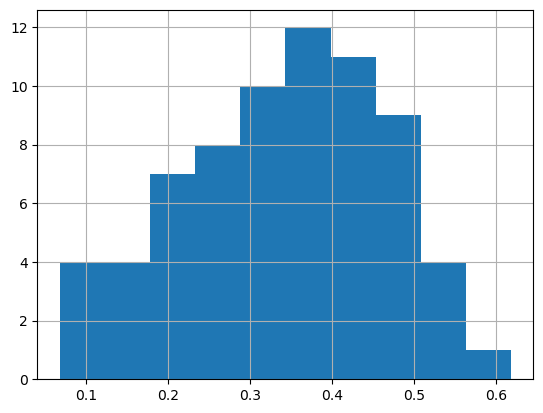

In [212]:
# Creating our histogram
filtered_df['similarity'].hist()

(-2.0, 36.75)

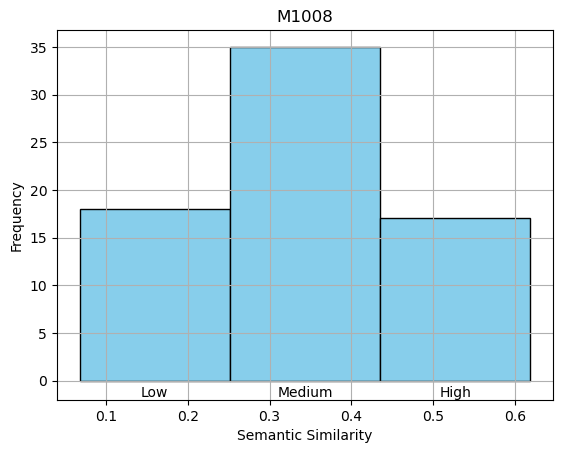

In [213]:
# Now to customize and label
filtered_df['similarity'].hist(bins=3, color= 'skyblue', edgecolor= 'black')
plt.title('M1008')
plt.xlabel('Semantic Similarity')
plt.ylabel('Frequency')
counts, bin_edges = np.histogram(filtered_df['similarity'], bins=3)

# Calculate center positions of each bin
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Add category labels under the bars
for center, label in zip(bin_centers, ['Low', 'Medium', 'High']):
    plt.text(center, -0.5, label, ha='center', va='top', fontsize=10)

# Make room below the plot for the labels
plt.ylim(bottom=-2)

### Creating Diagrams to Display Recall Accuracy vs. Semantic Similarity

In [214]:
filtered_df = filtered_df.copy()

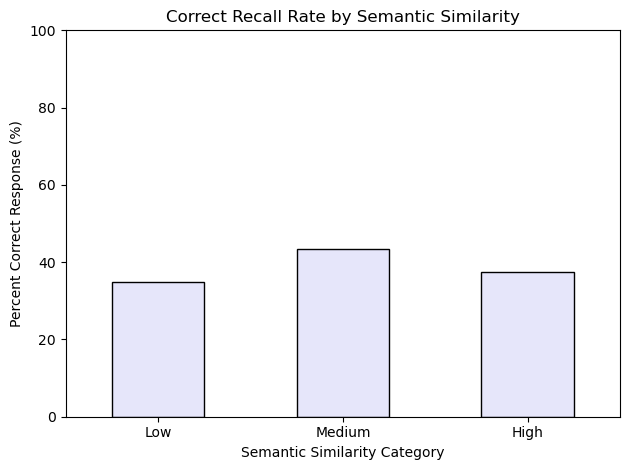

In [216]:
# Sort the dataframe by similarity
sorted_df = filtered_df.sort_values(by='similarity')

# Split into 3 equal-sized bins, based on number of items per bin, not range size
sorted_df['sim_bin'] = pd.qcut(sorted_df['similarity'], q=3, labels=['Low', 'Medium', 'High'])

# Making sure the total includes missing responses (NaN) too
def custom_percent(series):
    total = len(series)                    # Includes NaNs
    correct = (series == 'correct').sum() # Only count actual 'correct'
    return (correct / total) * 100

# Calculate percent of "correct" responses 
grouped = sorted_df.groupby('sim_bin', observed=True)
percent_correct = grouped['results'].apply(custom_percent)

# Plot the bar graph
percent_correct.plot(kind='bar', color='lavender', edgecolor='black')

# Formatting and labeling the graph
plt.ylabel('Percent Correct Response (%)')
plt.xlabel('Semantic Similarity Category')
plt.title('Correct Recall Rate by Semantic Similarity')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()                               

#### Checking that the data was broken up equally into terciles

In [217]:
sorted_df[sorted_df['sim_bin'] == 'Low']

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin
45,1,3,0,False,True,"[PEA, RICE]",[PEA],[RICE],0.067953,"[[662.1541950113378, 197, RICE]]",correct,Low
61,1,8,1,False,False,"[CART, GLOBE]",[CART],[GLOBE],0.094871,"[[3249.637188208617, -1, OLD], [3932.8571428571427, -1, <>], [4932.857142857143, -1, <>]]",intrusion,Low
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,Low
49,1,4,1,False,False,"[DOCK, WASP]",[DOCK],[WASP],0.119578,"[[3404.0362811791383, -1, <>]]",NaN,Low
17,0,5,2,False,True,"[DART, CHIN]",[DART],[CHIN],0.137147,"[[0.0, -1, <>], [1000.0, -1, <>], [2000.0, -1, <>], [5625.283446712018, -1, <>]]",NaN,Low
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,Low
26,0,8,2,True,False,"[APE, CARD]",[APE],[CARD],0.165837,"[[1452.3809523809523, -1, <>], [2452.3809523809527, -1, <>]]",NaN,Low
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD],0.172631,"[[4398.820861678004, -1, <>]]",NaN,Low
68,1,10,2,False,True,"[COOK, JAR]",[COOK],[JAR],0.189452,"[[5890.9977324263045, -1, <>], [6890.9977324263045, -1, <>], [7890.9977324263045, -1, <>]]",NaN,Low
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG],0.195994,"[[954.0362811791383, 162, MUG]]",correct,Low


In [218]:
sorted_df[sorted_df['sim_bin'] == 'Medium']

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,Medium
12,0,4,0,False,False,"[FILM, CHEST]",[FILM],[CHEST],0.291381,"[[3069.6825396825398, -1, <>], [4069.6825396825398, -1, <>]]",NaN,Medium
7,0,2,1,True,False,"[EEL, PRINCE]",[EEL],[PRINCE],0.292707,"[[1727.936507936508, -1, <>], [2880.8843537414964, 188, PRINCE]]",correct,Medium
53,1,5,2,True,False,"[OX, SPRING]",[OX],[SPRING],0.299427,"[[1444.671201814059, -1, <>], [2444.671201814059, -1, <>], [3444.671201814059, -1, <>], [5304.988662131519, -1, <>], [6304.988662131519, -1, <>], [7304.988662131519, -1, <>]]",NaN,Medium
9,0,3,0,True,False,"[SOUP, STAR]",[SOUP],[STAR],0.311673,"[[1039.501133786848, 252, STAR]]",correct,Medium
66,1,10,0,False,True,"[GATE, BOOT]",[GATE],[BOOT],0.314000,"[[4179.274376417234, -1, <>], [5179.274376417234, -1, <>], [6179.274376417234, -1, <>], [7179.274376417234, -1, <>]]",NaN,Medium
33,0,11,0,False,False,"[CROWN, GEESE]",[CROWN],[GEESE],0.314459,"[[4403.469387755102, -1, <>]]",NaN,Medium
67,1,10,1,False,True,"[ROAD, CLAM]",[ROAD],[CLAM],0.322838,"[[2258.9115646258506, 53, CLAM], [3358.0725623582766, -1, <>], [5064.693877551021, -1, <>]]",correct,Medium
20,0,6,2,False,True,"[STAIR, SPOUSE]",[STAIR],[SPOUSE],0.330505,"[[2322.7437641723354, -1, <>], [3322.7437641723354, -1, <>], [4322.743764172336, -1, <>], [5322.743764172336, -1, <>], [6322.743764172336, -1, <>], [7322.743764172336, -1, <>]]",NaN,Medium
57,1,7,0,True,False,"[INK, SLUG]",[INK],[SLUG],0.331121,"[[1854.8526077097506, 230, SLUG]]",correct,Medium


In [220]:
sorted_df[sorted_df['sim_bin'] == 'High']

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,High
43,1,2,1,True,False,"[VAULT, SLIDE]",[VAULT],[SLIDE],0.407662,"[[3202.5850340136058, -1, <>], [4202.585034013605, -1, <>], [5202.585034013605, -1, <>]]",NaN,High
35,0,11,2,False,False,"[CHIEF, HOLE]",[CHIEF],[HOLE],0.407807,"[[2349.5238095238096, 119, HOLE]]",correct,High
51,1,5,0,True,False,"[SHELL, MOOSE]",[SHELL],[MOOSE],0.415486,"[[1276.077097505669, 157, MOOSE]]",correct,High
41,1,1,2,False,True,"[SKATE, STREET]",[SKATE],[STREET],0.421284,"[[1132.3356009070296, 262, STREET], [5452.1768707483, -1, <>], [6452.1768707483, -1, <>]]",correct,High
14,0,4,2,False,False,"[CAGE, FRAME]",[CAGE],[FRAME],0.430342,"[[4144.331065759637, -1, <>], [4537.414965986395, 152, MAT], [4996.39455782313, -1, <>], [5558.299319727891, 95, FRAME], [7631.746031746032, 95, FRAME]]",correct,High
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,High
27,0,9,0,False,True,"[TOOL, WOLF]",[TOOL],[WOLF],0.438965,"[[2153.9455782312925, -1, <>]]",NaN,High
44,1,2,2,True,False,"[HEART, STEAM]",[HEART],[STEAM],0.441509,"[[3633.3786848072564, -1, SOUL], [4318.91156462585, -1, <>], [5318.91156462585, -1, <>], [6318.911564625851, -1, <>]]",intrusion,High
23,0,7,2,False,False,"[SHEET, TENT]",[SHEET],[TENT],0.449866,"[[3903.1519274376415, -1, <>]]",NaN,High


### Graphing the Results Accross Stimulus Conditions

In [221]:
correct_df = filtered_df[filtered_df['results'] == 'correct']
intrusion_df = filtered_df[filtered_df['results'] == 'intrusion']

In [222]:
# Adding a coulumn for stim conditions using the booleanvalues in stimEnc and stimCR
conditions = [
    (sorted_df['stimEnc'] == False) & (sorted_df['stimCR'] == False),
    (sorted_df['stimEnc'] == True) & (sorted_df['stimCR'] == False),
    (sorted_df['stimEnc'] == False) & (sorted_df['stimCR'] == True)
]

choices = ['noStim', 'stimEnc', 'stimCR']

sorted_df['stim_condition'] = np.select(conditions, choices, default='unknown')
sorted_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,sim_bin,stim_condition
45,1,3,0,False,True,"[PEA, RICE]",[PEA],[RICE],0.067953,"[[662.1541950113378, 197, RICE]]",correct,Low,stimCR
61,1,8,1,False,False,"[CART, GLOBE]",[CART],[GLOBE],0.094871,"[[3249.637188208617, -1, OLD], [3932.8571428571427, -1, <>], [4932.857142857143, -1, <>]]",intrusion,Low,noStim
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,Low,stimEnc
49,1,4,1,False,False,"[DOCK, WASP]",[DOCK],[WASP],0.119578,"[[3404.0362811791383, -1, <>]]",NaN,Low,noStim
17,0,5,2,False,True,"[DART, CHIN]",[DART],[CHIN],0.137147,"[[0.0, -1, <>], [1000.0, -1, <>], [2000.0, -1, <>], [5625.283446712018, -1, <>]]",NaN,Low,stimCR
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,Low,stimEnc
26,0,8,2,True,False,"[APE, CARD]",[APE],[CARD],0.165837,"[[1452.3809523809523, -1, <>], [2452.3809523809527, -1, <>]]",NaN,Low,stimEnc
6,0,2,0,True,False,"[BAT, BREAD]",[BAT],[BREAD],0.172631,"[[4398.820861678004, -1, <>]]",NaN,Low,stimEnc
68,1,10,2,False,True,"[COOK, JAR]",[COOK],[JAR],0.189452,"[[5890.9977324263045, -1, <>], [6890.9977324263045, -1, <>], [7890.9977324263045, -1, <>]]",NaN,Low,stimCR
2,0,0,2,False,False,"[POOL, MUG]",[POOL],[MUG],0.195994,"[[954.0362811791383, 162, MUG]]",correct,Low,noStim


In [ ]:
# Count how many are correct per group
# grouped = filtered_df.groupby(['sim_bin', 'stim_condition'])['correct'].agg(['mean', 'count'])

# Reshape into a DataFrame for plotting
# This puts stim_conditions as columns, and similarity_bin as index
# plot_data = grouped['mean'].unstack(fill_value=0)

# Sort x-axis bins in logical order
# plot_data = plot_data.reindex(['low', 'med', 'high'])

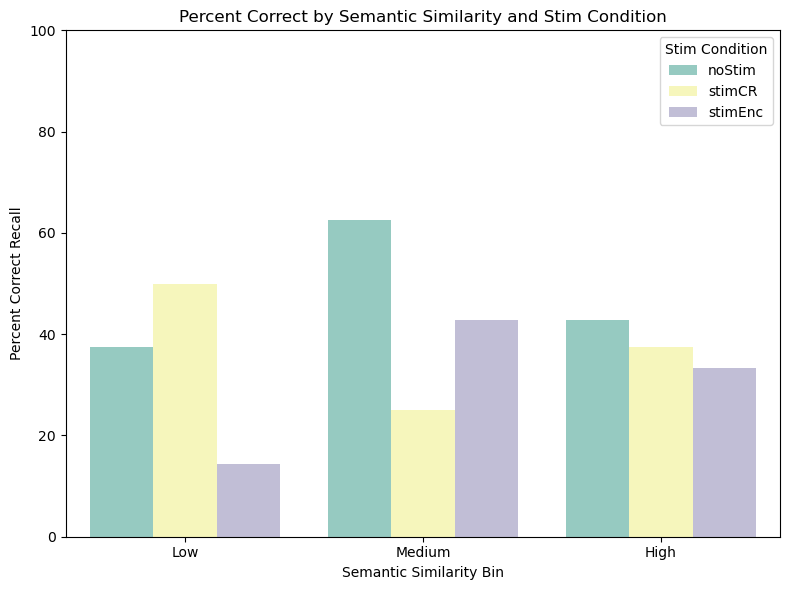

In [223]:

# Filter only correct trials
correct_df = sorted_df[sorted_df['results'] == 'correct']

# Count corrects per (sim_bin, stim_condition)
correct_counts = correct_df.groupby(['sim_bin', 'stim_condition'], observed=True).size().reset_index(name='correct_count')

# Count total trials per (sim_bin, stim_condition)
total_counts = sorted_df.groupby(['sim_bin', 'stim_condition'], observed=True).size().reset_index(name='total_count')

# Merge and calculate percent correct
merged = pd.merge(total_counts, correct_counts, on=['sim_bin', 'stim_condition'], how='left')
merged['correct_count'] = merged['correct_count'].fillna(0)  # fill missing with 0
merged['percent_correct'] = (merged['correct_count'] / merged['total_count']) * 100

# Plot grouped bar chart 
plt.figure(figsize=(8, 6))
sns.barplot(data=merged, x='sim_bin', y='percent_correct', hue='stim_condition', palette='Set3')

plt.xlabel('Semantic Similarity Bin')
plt.ylabel('Percent Correct Recall')
plt.title('Percent Correct by Semantic Similarity and Stim Condition')
plt.ylim(0, 100)
plt.legend(title='Stim Condition')
plt.tight_layout()
plt.show()

## Semantic Similarity Analyses of Intruded Words

In [238]:
# Pull intruded words from the data column
def extract_intruded_word(cell):
    matches = re.findall(r'\[.*?,.*?,\s*([^\[\],<> ]+)\]', str(cell))
    return matches[-1] if matches else None

# Apply the function to the intrusion dataframe
intrusion_df = intrusion_df.copy()
intrusion_df['intruded_word'] = intrusion_df['data'].apply(extract_intruded_word)

In [237]:
intrusion_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',None
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',None
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',None
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',None
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',None
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',None
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',None
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',None
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',None
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',None


In [253]:
# Making sure everything is a clean string that word2vec can process
def clean_word(word):
    # If it's a list, extract the first element
    if isinstance(word, list) and len(word) > 0:
        word = word[0]
    
    # If it's not a string now, something is wrong
    if not isinstance(word, str):
        return None
    
    # Remove brackets, quotes, whitespace, and make sure everything is uppercase
    cleaned = re.sub(r"[\[\]'\" ]", "", word)
    return cleaned.upper() if cleaned else None

In [256]:
# Get similarity for cue vs. intrusion word pair
def get_similarity(row):
    word1 = clean_word(row['cue'])
    word2 = clean_word(row['intruded_word'])
    
    if not word1 or not word2:
        return None
    if word1 not in word2vec.key_to_index or word2 not in word2vec.key_to_index:
        return None
    return word2vec.similarity(word1, word2)

intrusion_df['cue_intrusion_sim'] = intrusion_df.apply(get_similarity, axis=1)
intrusion_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',0.275967,None
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',0.466866,None
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',0.322973,None
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',0.240876,None
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',0.483425,None
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',0.499937,None
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',0.367242,None
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',0.257644,None
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',0.578822,None
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',0.187514,None


In [258]:
# get similarity for nonCue vs. intrusion word pair
def get_similarity2(row):
    word1 = clean_word(row['nonCue'])
    word2 = clean_word(row['intruded_word'])
    
    if not word1 or not word2:
        return None
    if word1 not in word2vec.key_to_index or word2 not in word2vec.key_to_index:
        return None
    return word2vec.similarity(word1, word2)

intrusion_df['nonCue_intrusion_sim'] = intrusion_df.apply(get_similarity2, axis=1)
intrusion_df

,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',0.275967,0.402648
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',0.466866,0.289977
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',0.322973,0.456109
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',0.240876,0.163899
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',0.483425,0.559136
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',0.499937,0.409961
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',0.367242,0.093817
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',0.257644,0.151485
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',0.578822,0.375288
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',0.187514,0.522830


#### Making our graphs

In [261]:
# First add stim conditions to this new dataframe
conditions = [
    (intrusion_df['stimEnc'] == False) & (intrusion_df['stimCR'] == False),
    (intrusion_df['stimEnc'] == True) & (intrusion_df['stimCR'] == False),
    (intrusion_df['stimEnc'] == False) & (intrusion_df['stimCR'] == True)
]

choices = ['noStim', 'stimEnc', 'stimCR']

intrusion_df['stim_condition'] = np.select(conditions, choices, default='unknown')
intrusion_df


,session,trial,item,stimEnc,stimCR,pairedWords,cue,nonCue,similarity,data,results,intruded_word,cue_intrusion_sim,nonCue_intrusion_sim,stim_condition
0,0,0,0,False,False,"[GOLD, BLUSH]",[GOLD],[BLUSH],0.371660,"[[0.0, -1, <>], [2350.884353741497, -1, LUSH]]",intrusion,'LUSH',0.275967,0.402648,noStim
4,0,1,1,False,True,"[HORN, SPARK]",[HORN],[SPARK],0.288528,"[[2341.9954648526077, 112, GROUND]]",intrusion,'GROUND',0.466866,0.289977,stimCR
5,0,1,2,False,True,"[GIFT, TOAST]",[GIFT],[TOAST],0.399273,"[[4954.739229024943, -1, SHARP]]",intrusion,'SHARP',0.322973,0.456109,stimCR
8,0,2,2,True,False,"[PIT, THIEF]",[PIT],[THIEF],0.209416,"[[3163.5827664399094, 11, BAT]]",intrusion,'BAT',0.240876,0.163899,stimEnc
11,0,3,2,True,False,"[BENCH, STRING]",[BENCH],[STRING],0.468091,"[[3052.290249433107, -1, <>], [3298.049886621315, -1, SPINNING], [4656.530612244898, -1, <>]]",intrusion,'SPINNING',0.483425,0.559136,stimEnc
19,0,6,1,False,True,"[MOLE, FOOD]",[MOLE],[FOOD],0.407531,"[[3517.7551020408164, 119, HOLE], [5681.768707482993, -1, <>]]",intrusion,'HOLE',0.499937,0.409961,stimCR
24,0,8,0,True,False,"[DUST, SAIL]",[DUST],[SAIL],0.119043,"[[3548.1179138321995, -1, WIND]]",intrusion,'WIND',0.367242,0.093817,stimEnc
25,0,8,1,True,False,"[FUR, WING]",[FUR],[WING],0.362919,"[[3032.3129251700684, -1, <>], [4032.312925170068, -1, <>], [5032.3129251700675, -1, <>], [5636.485260770975, 2, APE], [6682.222222222223, -1, <>]]",intrusion,'APE',0.257644,0.151485,stimEnc
30,0,10,0,True,False,"[BROOK, VEST]",[BROOK],[VEST],0.433599,"[[2493.106575963719, -1, <>], [3186.643990929705, -1, FISH], [6535.918367346939, 290, TROUT], [7044.285714285715, -1, <>]]",intrusion,'TROUT',0.578822,0.375288,stimEnc
31,0,10,1,True,False,"[WAND, FLAME]",[WAND],[FLAME],0.153418,"[[1140.952380952381, -1, FIRE]]",intrusion,'FIRE',0.187514,0.522830,stimEnc


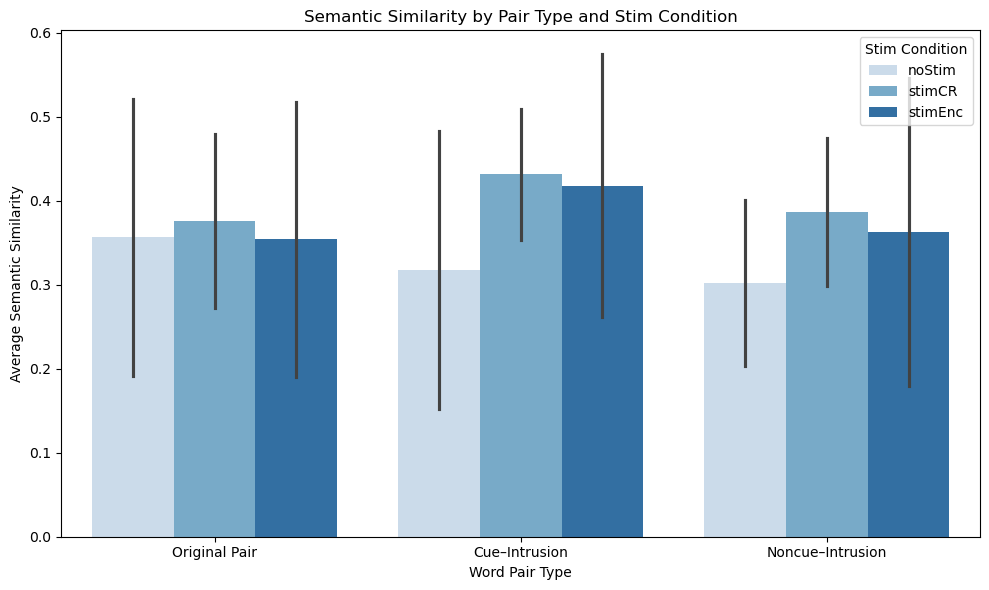

In [291]:
# Step 1: Melt the dataframe — reshape it to long format
melted = pd.melt(
    intrusion_df,
    id_vars=['stim_condition'],
    value_vars=['similarity', 'cue_intrusion_sim', 'nonCue_intrusion_sim'],
    var_name='pair_type',
    value_name='similarity_value'
)

# Step 2: Clean up the labels for pair_type for clarity (optional)
label_map = {
    'similarity': 'Original Pair',
    'cue_intrusion_sim': 'Cue–Intrusion',
    'nonCue_intrusion_sim': 'Noncue–Intrusion'
}
melted['pair_type'] = melted['pair_type'].map(label_map)

# Step 3: Drop rows where similarity is NaN (if any)
melted = melted.dropna(subset=['similarity_value'])

# Step 4: Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=melted,
    x='pair_type',
    y='similarity_value',
    hue='stim_condition',
    errorbar='sd',
    palette=sns.color_palette("Blues", 3)
)
plt.title("Semantic Similarity by Pair Type and Stim Condition")
plt.xlabel("Word Pair Type")
plt.ylabel("Average Semantic Similarity")
plt.legend(title="Stim Condition")
plt.tight_layout()
plt.show()

In [292]:
# Make a copy to edit and analize across different subjects
!cp Semantic_Similarity_Project.ipynb Semantic_Similarity_allSubjects.ipynb

In [293]:
!ls

GoogleNews-vectors.bin	      Patient_Data
Herz_Original_word2vec.ipynb  Semantic_Similarity_allSubjects.ipynb
Herz_semamticsim.ipynb	      Semantic_Similarity_Project.ipynb
M1008_DataReport2025.ipynb    word2vec-GoogleNews-vectors
M1008_Project.ipynb


In [ ]:
# 

In [ ]:
sem_sim_vec=[]
for row in temp_enc_cr_df:
    two_items=row["pairedWords"]
    
    value=semantic_sim...(0.3)
    sem_sim_vec = sem_sim_vec+value
    len(sem_sim_vec)==len(temp_enc_cr_df)
    
temp_enc_cr_df['sem_sim_value']=sem_sim_vec